# Gensim Tutorial on Online Non-Negative Matrix Factorization

This notebooks explains basic ideas behind the open source NMF implementation in [Gensim](https://github.com/RaRe-Technologies/gensim), including code examples for applying NMF to text processing.

## What's in this tutorial?

1. [Introduction: Why NMF?](#1.-Introduction-to-NMF)
2. [Code example on 20 Newsgroups](#2.-Code-example:-NMF-on-20-Newsgroups)
3. [Benchmarks against Sklearn's NMF and Gensim's LDA](#3.-Benchmarks)
4. [Large-scale NMF training on the English Wikipedia (sparse text vectors)](#4.-NMF-on-English-Wikipedia)
5. [NMF on face decomposition (dense image vectors)](#5.-And-now-for-something-completely-different:-Face-decomposition-from-images)

# 1. Introduction to NMF

## What's in a name?

Gensim's Online Non-Negative Matrix Factorization (NMF, NNMF, ONMF) implementation is based on [Renbo Zhao, Vincent Y. F. Tan: Online Nonnegative Matrix Factorization with Outliers, 2016](https://arxiv.org/abs/1604.02634) and is optimized for extremely large, sparse, streamed inputs. Such inputs happen in NLP with **unsupervised training** on massive text corpora.

* Why **Online**? Because corpora and datasets in modern ML can be very large, and RAM is limited. Unlike batch algorithms, online algorithms learn iteratively, streaming through the available training examples, without loading the entire dataset into RAM or requiring random-access to the data examples.

* Why **Non-Negative**? Because non-negativity leads to more interpretable, sparse "human-friendly" topics. This is in contrast to e.g. SVD (another popular matrix factorization method with [super-efficient implementation in Gensim](https://radimrehurek.com/gensim/models/lsimodel.html)), which produces dense negative factors and thus harder-to-interpret topics.

* **Matrix factorizations** are the corner stone of modern machine learning. They can be used either directly (recommendation systems, bi-clustering, image compression, topic modeling…) or as internal routines in more complex deep learning algorithms.

## How ONNMF works

Terminology:
- `corpus` is a stream of input documents = training examples
- `batch` is a chunk of input corpus, a word-document matrix mini-batch that fits in RAM
- `W` is a word-topic matrix (to be learned; stored in the resulting model)
- `h` is a topic-document matrix (to be learned; not stored, but rather inferred for documents on-the-fly)
- `A`, `B` - matrices that accumulate information from consecutive chunks. `A = h.dot(ht)`, `B = v.dot(ht)`.

The idea behind the algorithm is as follows:

```
    Initialize W, A and B matrices

    for batch in input corpus batches:
        infer h:
            do coordinate gradient descent step to find h that minimizes ||batch - Wh|| in L2 norm

            bound h so that it is non-negative

        update A and B:
            A = h.dot(ht)
            B = batch.dot(ht)

        update W:
            do gradient descent step to find W that minimizes ||0.5*trace(WtWA) - trace(WtB)|| in L2 norm
```

# 2. Code example: NMF on 20 Newsgroups

## Preprocessing

Let's import the models we'll be using throughout this tutorial (`numpy==1.14.2`, `matplotlib==3.0.2`, `pandas==0.24.1`, `sklearn==0.19.1`, `gensim==3.7.1`) and set up logging at INFO level.

Gensim uses logging generously to inform users what's going on. Eyeballing the logs is a good sanity check, to make sure everything is working as expected.

Only `numpy` and `gensim` are actually needed to train and use NMF. The other imports are used only to make our life a little easier in this tutorial.

In [1]:
import logging
import time
from contextlib import contextmanager
import os
from multiprocessing import Process
import psutil

import numpy as np
import pandas as pd
from numpy.random import RandomState
from sklearn import decomposition
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition.nmf import NMF as SklearnNmf
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score

import gensim.downloader
from gensim import matutils, utils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, TfidfModel
from gensim.models.basemodel import BaseTopicModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### Dataset preparation

Let's load the notorious [20 Newsgroups dataset](http://qwone.com/~jason/20Newsgroups/) from Gensim's [repository of pre-trained models and corpora](https://github.com/RaRe-Technologies/gensim-data):

In [2]:
newsgroups = gensim.downloader.load('20-newsgroups')

categories = [
    'alt.atheism',
    'comp.graphics',
    'rec.motorcycles',
    'talk.politics.mideast',
    'sci.space'
]

categories = {name: idx for idx, name in enumerate(categories)}

Create a train/test split:

In [3]:
random_state = RandomState(42)

trainset = np.array([
    {
        'data': doc['data'],
        'target': categories[doc['topic']],
    }
    for doc in newsgroups
    if doc['topic'] in categories and doc['set'] == 'train'
])
random_state.shuffle(trainset)

testset = np.array([
    {
        'data': doc['data'],
        'target': categories[doc['topic']],
    }
    for doc in newsgroups
    if doc['topic'] in categories and doc['set'] == 'test'
])
random_state.shuffle(testset)

We'll use very [simple preprocessing with stemming](https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string) to tokenize each document. YMMV; in your application, use whatever preprocessing makes sense in your domain. Correctly preparing the input has [major impact](https://en.wikipedia.org/wiki/Garbage_in,_garbage_out) on any subsequent ML training.

In [4]:
train_documents = [preprocess_string(doc['data']) for doc in trainset]
test_documents = [preprocess_string(doc['data']) for doc in testset]

### Dictionary compilation

Let's create a mapping between tokens and their ids. Another option would be a [HashDictionary](https://radimrehurek.com/gensim/corpora/hashdictionary.html), saving ourselves one pass over the training documents.

In [5]:
dictionary = Dictionary(train_documents)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=20000)  # filter out too in/frequent tokens

2019-03-04 01:54:20,844 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-03-04 01:54:21,153 : INFO : built Dictionary(25279 unique tokens: ['gladli', 'garrett', 'stuck', 'gov', 'karasi']...) from 2819 documents (total 435328 corpus positions)
2019-03-04 01:54:21,182 : INFO : discarding 18198 tokens: [('batka', 1), ('batkaj', 1), ('beatl', 1), ('ccmail', 3), ('dayton', 4), ('edu', 1785), ('inhibit', 1), ('jbatka', 1), ('line', 2748), ('organ', 2602)]...
2019-03-04 01:54:21,183 : INFO : keeping 7081 tokens which were in no less than 5 and no more than 1409 (=50.0%) documents
2019-03-04 01:54:21,193 : INFO : resulting dictionary: Dictionary(7081 unique tokens: ['gladli', 'run', 'trillion', 'stuck', 'order']...)


### Create training corpus

Let's vectorize the training corpus into the bag-of-words format. We'll train LDA on a BOW and NMFs on an TF-IDF corpus:

In [6]:
tfidf = TfidfModel(dictionary=dictionary)

train_corpus = [
    dictionary.doc2bow(document)
    for document
    in train_documents
]

test_corpus = [
    dictionary.doc2bow(document)
    for document
    in test_documents
]

train_corpus_tfidf = list(tfidf[train_corpus])

test_corpus_tfidf = list(tfidf[test_corpus])

Here we simply stored the bag-of-words vectors into a `list`, but Gensim accepts [any iterable](https://radimrehurek.com/gensim/tut1.html#corpus-streaming-one-document-at-a-time) as input, including streamed ones. To learn more about memory-efficient input iterables, see our [Data Streaming in Python: Generators, Iterators, Iterables](https://rare-technologies.com/data-streaming-in-python-generators-iterators-iterables/) tutorial.

## NMF Model Training

The API works in the same way as other Gensim models, such as [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html) or [LsiModel](https://radimrehurek.com/gensim/models/lsimodel.html).

Notable model parameters:

- `kappa` float, optional

    Gradient descent step size.
    Larger value makes the model train faster, but could lead to non-convergence if set too large.
    
- `w_max_iter` int, optional

    Maximum number of iterations to train W per each batch.
    
- `w_stop_condition` float, optional

    If the error difference gets smaller than this, training of ``W`` stops for the current batch.
    
- `h_r_max_iter` int, optional

    Maximum number of iterations to train h per each batch.
    
- `h_r_stop_condition` float, optional

    If the error difference gets smaller than this, training of ``h`` stops for the current batch.

Learn an NMF model with 5 topics:

In [7]:
%%time

nmf = GensimNmf(
    corpus=train_corpus_tfidf,
    num_topics=5,
    id2word=dictionary,
    chunksize=1000,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=0,
    kappa=1,
)

2019-03-04 01:54:24,559 : INFO : running NMF training, 5 topics, 5 passes over the supplied corpus of 2819 documents, evaluating l2 norm every 2819 documents
2019-03-04 01:54:24,574 : INFO : PROGRESS: pass 0, at document #1000/2819
2019-03-04 01:54:24,589 : INFO : W error diff: -inf
2019-03-04 01:54:24,604 : INFO : PROGRESS: pass 0, at document #2000/2819
2019-03-04 01:54:24,615 : INFO : W error diff: -2.1783593508632997
2019-03-04 01:54:24,626 : INFO : PROGRESS: pass 0, at document #2819/2819
2019-03-04 01:54:24,722 : INFO : L2 norm: 28.137070033533682
2019-03-04 01:54:24,756 : INFO : topic #0 (0.404): 0.011*"isra" + 0.010*"israel" + 0.007*"arab" + 0.006*"jew" + 0.005*"palestinian" + 0.004*"henri" + 0.003*"toronto" + 0.003*"question" + 0.003*"kill" + 0.003*"polici"
2019-03-04 01:54:24,757 : INFO : topic #1 (0.358): 0.009*"space" + 0.005*"access" + 0.005*"nasa" + 0.004*"pat" + 0.003*"digex" + 0.003*"orbit" + 0.003*"shuttl" + 0.003*"graphic" + 0.003*"data" + 0.003*"com"
2019-03-04 01:54

CPU times: user 1.52 s, sys: 1.84 s, total: 3.36 s
Wall time: 944 ms


### View the learned topics

In [8]:
nmf.show_topics()

[(0,
  '0.015*"israel" + 0.014*"isra" + 0.009*"arab" + 0.008*"jew" + 0.005*"palestinian" + 0.004*"lebanes" + 0.004*"peac" + 0.004*"attack" + 0.004*"lebanon" + 0.003*"polici"'),
 (1,
  '0.007*"space" + 0.005*"nasa" + 0.003*"access" + 0.003*"orbit" + 0.003*"launch" + 0.003*"gov" + 0.003*"pat" + 0.003*"com" + 0.002*"alaska" + 0.002*"moon"'),
 (2,
  '0.023*"armenian" + 0.012*"turkish" + 0.008*"armenia" + 0.007*"argic" + 0.007*"turk" + 0.007*"serdar" + 0.006*"turkei" + 0.005*"greek" + 0.005*"genocid" + 0.005*"soviet"'),
 (3,
  '0.017*"moral" + 0.016*"keith" + 0.008*"object" + 0.007*"caltech" + 0.006*"schneider" + 0.006*"allan" + 0.006*"cco" + 0.004*"anim" + 0.004*"natur" + 0.004*"goal"'),
 (4,
  '0.012*"god" + 0.011*"islam" + 0.006*"jaeger" + 0.005*"sgi" + 0.005*"livesei" + 0.005*"muslim" + 0.005*"atheist" + 0.005*"religion" + 0.005*"atheism" + 0.004*"rushdi"')]

### Evaluation measure: Coherence

[Topic coherence](http://qpleple.com/topic-coherence-to-evaluate-topic-models/) measures how often do most frequent tokens from each topic co-occur in one document. Larger is better.

In [9]:
CoherenceModel(
    model=nmf,
    corpus=test_corpus_tfidf,
    coherence='u_mass'
).get_coherence()

2019-03-04 01:54:25,582 : INFO : CorpusAccumulator accumulated stats from 1000 documents


-4.045883079644641

## Topic inference on new documents

With the NMF model trained, let's fetch one news document not seen during training, and infer its topic vector.

In [10]:
print(testset[0]['data'])
print('=' * 100)
print("Topics: {}".format(nmf[test_corpus[0]]))

From: spl@ivem.ucsd.edu (Steve Lamont)
Subject: Re: RGB to HVS, and back
Organization: University of Calif., San Diego/Microscopy and Imaging Resource
Lines: 18
Distribution: world
NNTP-Posting-Host: ivem.ucsd.edu

In article <ltu4buINNe7j@caspian.usc.edu> zyeh@caspian.usc.edu (zhenghao yeh) writes:
>|> See Foley, van Dam, Feiner, and Hughes, _Computer Graphics: Principles
>|> and Practice, Second Edition_.
>|> 
>|> [If people would *read* this book, 75 percent of the questions in this
>|> froup would disappear overnight...]
>|> 
>	Not really. I think it is less than 10%.

Nah... I figure most people would be so busy reading that they wouldn't
have *time* to post. :-) :-) :-)

							spl
-- 
Steve Lamont, SciViGuy -- (619) 534-7968 -- spl@szechuan.ucsd.edu
San Diego Microscopy and Imaging Resource/UC San Diego/La Jolla, CA 92093-0608
"Until I meet you, then, in Upper Hell
Convulsed, foaming immortal blood: farewell" - J. Berryman, "A Professor's Song"

Topics: [(0, 0.10094349983895379)

## Word topic inference

Similarly, we can inspect the topic distribution assigned to a vocabulary term:

In [11]:
word = dictionary[0]
print("Word: {}".format(word))
print("Topics: {}".format(nmf.get_term_topics(word)))

Word: actual
Topics: [(0, 0.1517466731147538), (1, 0.2824521057319929), (2, 0.042590027339691805), (3, 0.2520757387076886), (4, 0.2711354551058729)]


### Internal NMF state

Density is a fraction of non-zero elements in a matrix.

In [12]:
def density(matrix):
    return (matrix > 0).mean()

Term-topic matrix of shape `(words, topics)`.

In [13]:
print("Density: {}".format(density(nmf._W)))

Density: 0.6864567151532269


Topic-document matrix for the last batch of shape `(topics, batch)`

In [14]:
print("Density: {}".format(density(nmf._h)))

Density: 0.662026862026862


# 3. Benchmarks

## Gensim NMF vs Sklearn NMF vs Gensim LDA

We'll run these three unsupervised models on the [20newsgroups](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) dataset.

20 Newsgroups also contains labels for each document, which will allow us to evaluate the trained models on an "upstream" classification task, using the unsupervised document topics as input features.

### Metrics

We'll track these metrics as we train and test NMF on the 20-newsgroups corpus we created above:
- `train time` - time to train a model
- `mean_ram` - mean RAM consumption during training
- `max_ram` - maximum RAM consumption during training
- `train time` - time to train a model.
- `coherence` - coherence score (larger is better).
- `l2_norm` - L2 norm of `v - Wh` (less is better, not defined for LDA).
- `f1` - [F1 score](https://en.wikipedia.org/wiki/F1_score) on the task of news topic classification (larger is better).

In [15]:
fixed_params = dict(
    chunksize=1000,
    num_topics=5,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=0,
)

In [16]:
@contextmanager
def measure_ram(output, tick=5):
    def _measure_ram(pid, output, tick=tick):
        py = psutil.Process(pid)
        with open(output, 'w') as outfile:
            while True:
                memory = py.memory_info().rss
                outfile.write("{}\n".format(memory))
                outfile.flush()
                time.sleep(tick)

    pid = os.getpid()
    p = Process(target=_measure_ram, args=(pid, output, tick))
    p.start()
    yield
    p.terminate()


def get_train_time_and_ram(func, name, tick=5):
    memprof_filename = "{}.memprof".format(name)

    start = time.time()

    with measure_ram(memprof_filename, tick=tick):
        result = func()

    elapsed_time = pd.to_timedelta(time.time() - start, unit='s').round('s')

    memprof_df = pd.read_csv(memprof_filename, squeeze=True)

    mean_ram = "{} MB".format(
        int(memprof_df.mean() // 2 ** 20),
    )

    max_ram = "{} MB".format(int(memprof_df.max() // 2 ** 20))

    return elapsed_time, mean_ram, max_ram, result


def get_f1(model, train_corpus, X_test, y_train, y_test):
    if isinstance(model, SklearnNmf):
        dense_train_corpus = matutils.corpus2dense(
            train_corpus,
            num_terms=model.components_.shape[1],
        )
        X_train = model.transform(dense_train_corpus.T)
    else:
        X_train = np.zeros((len(train_corpus), model.num_topics))
        for bow_id, bow in enumerate(train_corpus):
            for topic_id, word_count in model.get_document_topics(bow):
                X_train[bow_id, topic_id] = word_count

    log_reg = LogisticRegressionCV(multi_class='multinomial', cv=5)
    log_reg.fit(X_train, y_train)

    pred_labels = log_reg.predict(X_test)

    return f1_score(y_test, pred_labels, average='micro')

def get_sklearn_topics(model, top_n=5):
    topic_probas = model.components_.T
    topic_probas = topic_probas / topic_probas.sum(axis=0)

    sparsity = np.zeros(topic_probas.shape[1])

    for row in topic_probas:
        sparsity += (row == 0)

    sparsity /= topic_probas.shape[1]

    topic_probas = topic_probas[:, sparsity.argsort()[::-1]][:, :top_n]

    token_indices = topic_probas.argsort(axis=0)[:-11:-1, :]
    topic_probas.sort(axis=0)
    topic_probas = topic_probas[:-11:-1, :]

    topics = []

    for topic_idx in range(topic_probas.shape[1]):
        tokens = [
            model.id2word[token_idx]
            for token_idx
            in token_indices[:, topic_idx]
        ]
        topic = (
            '{}*"{}"'.format(round(proba, 3), token)
            for proba, token
            in zip(topic_probas[:, topic_idx], tokens)
        )
        topic = " + ".join(topic)
        topics.append((topic_idx, topic))

    return topics

def get_metrics(model, test_corpus, train_corpus=None, y_train=None, y_test=None, dictionary=None):
    if isinstance(model, SklearnNmf):
        model.get_topics = lambda: model.components_
        model.show_topics = lambda top_n: get_sklearn_topics(model, top_n)
        model.id2word = dictionary

    W = model.get_topics().T

    dense_test_corpus = matutils.corpus2dense(
        test_corpus,
        num_terms=W.shape[0],
    )

    if isinstance(model, SklearnNmf):
        H = model.transform(dense_test_corpus.T).T
    else:
        H = np.zeros((model.num_topics, len(test_corpus)))
        for bow_id, bow in enumerate(test_corpus):
            for topic_id, word_count in model.get_document_topics(bow):
                H[topic_id, bow_id] = word_count

    l2_norm = None

    if not isinstance(model, LdaModel):
        pred_factors = W.dot(H)

        l2_norm = np.linalg.norm(pred_factors - dense_test_corpus)
        l2_norm = round(l2_norm, 4)

    f1 = None

    if train_corpus and y_train and y_test:
        f1 = get_f1(model, train_corpus, H.T, y_train, y_test)
        f1 = round(f1, 4)

    model.normalize = True

    coherence = CoherenceModel(
        model=model,
        corpus=test_corpus,
        coherence='u_mass'
    ).get_coherence()
    coherence = round(coherence, 4)

    topics = model.show_topics(5)

    model.normalize = False

    return dict(
        coherence=coherence,
        l2_norm=l2_norm,
        f1=f1,
        topics=topics,
    )

### Run the models

In [17]:
tm_metrics = pd.DataFrame(columns=['model', 'train_time', 'coherence', 'l2_norm', 'f1', 'topics'])

y_train = [doc['target'] for doc in trainset]
y_test = [doc['target'] for doc in testset]

# LDA metrics
row = {}
row['model'] = 'lda'
row['train_time'], row['mean_ram'], row['max_ram'], lda = get_train_time_and_ram(
    lambda: LdaModel(
        corpus=train_corpus,
        **fixed_params,
    ),
    'lda',
    1,
)
row.update(get_metrics(
    lda, test_corpus, train_corpus, y_train, y_test,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

# Sklearn NMF metrics
row = {}
row['model'] = 'sklearn_nmf'
train_dense_corpus_tfidf = matutils.corpus2dense(train_corpus_tfidf, len(dictionary)).T
row['train_time'], row['mean_ram'], row['max_ram'], sklearn_nmf = get_train_time_and_ram(
    lambda: SklearnNmf(n_components=5, random_state=42).fit(train_dense_corpus_tfidf),
    'sklearn_nmf',
    1,
)
row.update(get_metrics(
    sklearn_nmf, test_corpus_tfidf, train_corpus_tfidf, y_train, y_test, dictionary,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

# Gensim NMF metrics
row = {}
row['model'] = 'gensim_nmf'
row['train_time'], row['mean_ram'], row['max_ram'], gensim_nmf = get_train_time_and_ram(
    lambda: GensimNmf(
        normalize=False,
        corpus=train_corpus_tfidf,
        **fixed_params
    ),
    'gensim_nmf',
    0.5,
)
row.update(get_metrics(
    gensim_nmf, test_corpus_tfidf, train_corpus_tfidf, y_train, y_test,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)
tm_metrics.replace(np.nan, '-', inplace=True)

## Benchmark results

In [18]:
tm_metrics.drop('topics', axis=1)

,model,train_time,coherence,l2_norm,f1,max_ram,mean_ram
0,lda,00:00:08,-2.1054,-,0.7511,288 MB,288 MB
1,sklearn_nmf,00:00:02,-3.1835,42.4759,0.7900,824 MB,692 MB
2,gensim_nmf,00:00:01,-4.0459,42.5486,0.8044,427 MB,427 MB


### Main insights

- Gensim NMF is **ridiculously fast** and leaves both LDA and Sklearn far behind in terms of training time and quality on downstream task (F1 score), though coherence is the lowest among all models.
- Gensim NMF beats Sklearn NMF in RAM consumption, but L2 norm is a bit worse.
- Gensim NMF consumes a bit more RAM than LDA.

### Learned topics

Let's inspect the 5 topics learned by each of the three models:

In [19]:
def compare_topics(tm_metrics):
    for _, row in tm_metrics.iterrows():
        print('\n{}:'.format(row.model))
        print("\n".join(str(topic) for topic in row.topics))
        
compare_topics(tm_metrics)


lda:
(0, '0.013*"space" + 0.008*"imag" + 0.007*"nasa" + 0.006*"graphic" + 0.006*"program" + 0.005*"launch" + 0.005*"file" + 0.005*"com" + 0.005*"new" + 0.004*"orbit"')
(1, '0.015*"com" + 0.007*"like" + 0.007*"nntp" + 0.007*"host" + 0.006*"know" + 0.006*"univers" + 0.005*"henri" + 0.005*"work" + 0.005*"bit" + 0.005*"think"')
(2, '0.014*"armenian" + 0.011*"peopl" + 0.009*"turkish" + 0.007*"jew" + 0.007*"said" + 0.006*"right" + 0.005*"know" + 0.005*"kill" + 0.005*"isra" + 0.005*"turkei"')
(3, '0.012*"com" + 0.010*"israel" + 0.009*"bike" + 0.006*"isra" + 0.006*"dod" + 0.005*"like" + 0.005*"ride" + 0.005*"host" + 0.005*"nntp" + 0.005*"motorcycl"')
(4, '0.011*"god" + 0.008*"peopl" + 0.007*"think" + 0.006*"exist" + 0.006*"univers" + 0.005*"com" + 0.005*"believ" + 0.005*"islam" + 0.005*"moral" + 0.005*"christian"')

sklearn_nmf:
(0, '0.027*"armenian" + 0.013*"turkish" + 0.009*"armenia" + 0.009*"argic" + 0.009*"serdar" + 0.008*"turk" + 0.007*"turkei" + 0.006*"genocid" + 0.006*"soviet" + 0.006*

Subjectively, Gensim and Sklearn NMFs are on par with each other, LDA looks a bit worse.

# 4. NMF on English Wikipedia

This section shows how to train an NMF model on a large text corpus, the entire English Wikipedia: **2.6 billion words, in 23.1 million article sections across 5 million Wikipedia articles**.

The data preprocessing takes a while, and we'll be comparing multiple models, so **reserve about FIXME hours** and some **20 GB of disk space** to go through the following notebook cells in full. You'll need `gensim>=3.7.1`, `numpy`, `tqdm`, `pandas`, `psutils`, `joblib` and `sklearn`.

In [20]:
# Re-import modules from scratch, so that this Section doesn't rely on any previous cells.
import itertools
import json
import logging
import time
import os

from smart_open import smart_open
import psutil
import numpy as np
import scipy.sparse
from contextlib import contextmanager, contextmanager, contextmanager
from multiprocessing import Process
from tqdm import tqdm, tqdm_notebook
import joblib
import pandas as pd
from sklearn.decomposition.nmf import NMF as SklearnNmf

import gensim.downloader
from gensim import matutils
from gensim.corpora import MmCorpus, Dictionary
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.utils import simple_preprocess

tqdm.pandas()

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Load the Wikipedia dump

We'll use the [gensim.downloader](https://github.com/RaRe-Technologies/gensim-data) to download a parsed Wikipedia dump (6.1 GB disk space):

In [21]:
data = gensim.downloader.load("wiki-english-20171001")

Print the titles and sections of the first Wikipedia article, as a little sanity check:

In [22]:
data = gensim.downloader.load("wiki-english-20171001")
article = next(iter(data))

print("Article: %r\n" % article['title'])
for section_title, section_text in zip(article['section_titles'], article['section_texts']):
    print("Section title: %r" % section_title)
    print("Section text: %s…\n" % section_text[:100].replace('\n', ' ').strip())

Article: 'Anarchism'

Section title: 'Introduction'
Section text: '''Anarchism''' is a political philosophy that advocates self-governed societies based on volun…

Section title: 'Etymology and terminology'
Section text: The word ''anarchism'' is composed from the word ''anarchy'' and the suffix ''-ism'', themselves d…

Section title: 'History'
Section text: ===Origins=== Woodcut from a Diggers document by William Everard  The earliest anarchist themes ca…

Section title: 'Anarchist schools of thought'
Section text: Portrait of philosopher Pierre-Joseph Proudhon (1809–1865) by Gustave Courbet. Proudhon was the pri…

Section title: 'Internal issues and debates'
Section text: consistent with anarchist values is a controversial subject among anarchists.  Anarchism is a philo…

Section title: 'Topics of interest'
Section text: Intersecting and overlapping between various schools of thought, certain topics of interest and inte…

Section title: 'Criticisms'
Section text: Criticisms of anarch

Let's create a Python generator function that streams through the downloaded Wikipedia dump and preprocesses (tokenizes, lower-cases) each article:

In [23]:
def wikidump2tokens(articles):
    """Stream through the Wikipedia dump, yielding a list of tokens for each article."""
    for article in articles:
        article_section_texts = [
            " ".join([title, text])
            for title, text
            in zip(article['section_titles'], article['section_texts'])
        ]
        article_tokens = simple_preprocess(" ".join(article_section_texts))
        yield article_tokens

Create a word-to-id mapping, in order to vectorize texts. Makes a full pass over the Wikipedia corpus, takes **~3.5 hours**:

In [24]:
if os.path.exists('wiki.dict'):
    # If we already stored the Dictionary in a previous run, simply load it, to save time.
    dictionary = Dictionary.load('wiki.dict')
else:
    dictionary = Dictionary(wikidump2tokens(data))
    # Keep only the 30,000 most frequent vocabulary terms, after filtering away terms
    # that are too frequent/too infrequent.
    dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=30000)
    dictionary.save('wiki.dict')

2019-03-04 01:54:48,345 : INFO : loading Dictionary object from wiki.dict
2019-03-04 01:54:48,371 : INFO : loaded wiki.dict


## Store preprocessed Wikipedia as bag-of-words sparse matrix in MatrixMarket format

When training NMF with a single pass over the input corpus ("online"), we simply vectorize each raw text straight from the input storage:

In [25]:
vector_stream = (dictionary.doc2bow(article) for article in wikidump2tokens(data))

For the purposes of this tutorial though, we'll serialize ("cache") the vectorized bag-of-words vectors to disk, to `wiki.mm` file in MatrixMarket format. The reason is, we'll be re-using the vectorized articles multiple times, for different models for our benchmarks, and also shuffling them, so it makes sense to amortize the vectorization time by persisting the resulting vectors to disk.

So, let's stream through the preprocessed sparse Wikipedia bag-of-words matrix while storing it to disk. **This step takes about 3 hours** and needs **38 GB of disk space**:

In [26]:
class RandomSplitCorpus(MmCorpus):
    """
    Use the fact that MmCorpus supports random indexing, and create a streamed
    corpus in shuffled order, including a train/test split for evaluation.
    """
    def __init__(self, random_seed=42, testset=False, testsize=1000, *args, **kwargs):
        super().__init__(*args, **kwargs)

        random_state = np.random.RandomState(random_seed)
        
        self.indices = random_state.permutation(range(self.num_docs))
        test_nnz = sum(len(self[doc_idx]) for doc_idx in self.indices[:testsize])
        
        if testset:
            self.indices = self.indices[:testsize]
            self.num_docs = testsize
            self.num_nnz = test_nnz
        else:
            self.indices = self.indices[testsize:]
            self.num_docs -= testsize
            self.num_nnz -= test_nnz

    def __iter__(self):
        for doc_id in self.indices:
            yield self[doc_id]

In [27]:
if not os.path.exists('wiki.mm'):
    MmCorpus.serialize('wiki.mm', vector_stream, progress_cnt=100000)

if not os.path.exists('wiki_tfidf.mm'):
    MmCorpus.serialize('wiki_tfidf.mm', tfidf[MmCorpus('wiki.mm')], progress_cnt=100000)

In [28]:
# Load back the vectors as two lazily-streamed train/test iterables.
train_corpus = RandomSplitCorpus(
    random_seed=42, testset=False, testsize=10000, fname='wiki.mm',
)
test_corpus = RandomSplitCorpus(
    random_seed=42, testset=True, testsize=10000, fname='wiki.mm',
)

train_corpus_tfidf = RandomSplitCorpus(
    random_seed=42, testset=False, testsize=10000, fname='wiki_tfidf.mm',
)
test_corpus_tfidf = RandomSplitCorpus(
    random_seed=42, testset=True, testsize=10000, fname='wiki_tfidf.mm',
)

2019-03-04 01:54:48,955 : INFO : loaded corpus index from wiki.mm.index
2019-03-04 01:54:48,955 : INFO : initializing cython corpus reader from wiki.mm
2019-03-04 01:54:48,957 : INFO : accepted corpus with 4924894 documents, 30000 features, 820242695 non-zero entries
2019-03-04 01:54:53,977 : INFO : loaded corpus index from wiki.mm.index
2019-03-04 01:54:53,979 : INFO : initializing cython corpus reader from wiki.mm
2019-03-04 01:54:53,981 : INFO : accepted corpus with 4924894 documents, 30000 features, 820242695 non-zero entries
2019-03-04 01:54:59,407 : INFO : loaded corpus index from wiki_tfidf.mm.index
2019-03-04 01:54:59,407 : INFO : initializing cython corpus reader from wiki_tfidf.mm
2019-03-04 01:54:59,408 : INFO : accepted corpus with 4924661 documents, 30000 features, 820007548 non-zero entries
2019-03-04 01:55:02,179 : INFO : loaded corpus index from wiki_tfidf.mm.index
2019-03-04 01:55:02,179 : INFO : initializing cython corpus reader from wiki_tfidf.mm
2019-03-04 01:55:02,

## Save preprocessed Wikipedia in scipy.sparse format

This is only needed to run the Sklearn NMF on Wikipedia, for comparison in the benchmarks below. Sklearn expects in-memory scipy sparse input, not on-the-fly vector streams. Needs additional ~2 GB of disk space.


**Skip this step if you don't need the Sklearn's NMF benchmark, and only want to run Gensim's NMF.**

In [29]:
if not os.path.exists('wiki_train_csr.npz'):
    scipy.sparse.save_npz(
        'wiki_train_csr.npz',
        matutils.corpus2csc(train_corpus_tfidf, len(dictionary)).T,
    )

### Metrics

We'll track these metrics as we train and test NMF on the Wikipedia corpus we created above:
- `train time` - time to train a model
- `mean_ram` - mean RAM consumption during training
- `max_ram` - maximum RAM consumption during training
- `train time` - time to train a model.
- `coherence` - coherence score (larger is better).
- `l2_norm` - L2 norm of `v - Wh` (less is better, not defined for LDA).

Define a dataframe in which we'll store the recorded metrics:

In [30]:
tm_metrics = pd.DataFrame(columns=[
    'model', 'train_time', 'mean_ram', 'max_ram', 'coherence', 'l2_norm', 'topics',
])

Define common parameters, to be shared by all evaluated models:

In [31]:
params = dict(
    chunksize=2000,
    num_topics=50,
    id2word=dictionary,
    passes=1,
    eval_every=10,
    minimum_probability=0,
    random_state=42,
)

## Wikipedia training

### Train Gensim NMF model and record its metrics

In [32]:
row = {}
row['model'] = 'gensim_nmf'
row['train_time'], row['mean_ram'], row['max_ram'], nmf = get_train_time_and_ram(
    lambda: GensimNmf(normalize=False, corpus=train_corpus_tfidf, **params),
    'gensim_nmf',
    1,
)

In [33]:
print(row)
nmf.save('gensim_nmf.model')

2019-03-04 02:22:13,520 : INFO : saving Nmf object under gensim_nmf.model, separately None


{'max_ram': '797 MB', 'train_time': Timedelta('0 days 00:27:09'), 'model': 'gensim_nmf', 'mean_ram': '794 MB'}


2019-03-04 02:22:13,853 : INFO : saved gensim_nmf.model


In [34]:
nmf = GensimNmf.load('gensim_nmf.model')
row.update(get_metrics(nmf, test_corpus_tfidf))
print(row)
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

2019-03-04 02:22:13,859 : INFO : loading Nmf object from gensim_nmf.model
2019-03-04 02:22:13,987 : INFO : loading id2word recursively from gensim_nmf.model.id2word.* with mmap=None
2019-03-04 02:22:13,988 : INFO : loaded gensim_nmf.model
2019-03-04 02:23:40,723 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2019-03-04 02:23:40,869 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2019-03-04 02:23:41,020 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2019-03-04 02:23:41,169 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2019-03-04 02:23:41,322 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2019-03-04 02:23:41,473 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2019-03-04 02:23:41,620 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2019-03-04 02:23:41,764 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2019-03-04 02:23:41,917 : INFO : CorpusAccumulato

{'topics': [(21, '0.009*"his" + 0.005*"that" + 0.005*"him" + 0.004*"had" + 0.003*"they" + 0.003*"who" + 0.003*"her" + 0.003*"but" + 0.003*"king" + 0.003*"were"'), (39, '0.005*"are" + 0.005*"or" + 0.004*"be" + 0.004*"that" + 0.003*"can" + 0.003*"used" + 0.003*"this" + 0.002*"have" + 0.002*"such" + 0.002*"which"'), (45, '0.091*"apelor" + 0.086*"bucurești" + 0.051*"river" + 0.046*"cadastrul" + 0.045*"hidrologie" + 0.045*"meteorologie" + 0.045*"institutul" + 0.045*"române" + 0.045*"româniei" + 0.045*"rîurile"'), (28, '0.066*"gmina" + 0.065*"poland" + 0.065*"voivodeship" + 0.046*"village" + 0.045*"administrative" + 0.042*"lies" + 0.037*"approximately" + 0.036*"east" + 0.031*"west" + 0.030*"county"'), (34, '0.087*"romanized" + 0.085*"iran" + 0.067*"province" + 0.067*"rural" + 0.066*"census" + 0.060*"families" + 0.054*"village" + 0.049*"county" + 0.047*"population" + 0.042*"district"')], 'mean_ram': '794 MB', 'l2_norm': 94.9842, 'model': 'gensim_nmf', 'max_ram': '797 MB', 'f1': None, 'train_t

### Train Gensim LDA and record its metrics

In [35]:
row = {}
row['model'] = 'lda'
row['train_time'], row['mean_ram'], row['max_ram'], lda = get_train_time_and_ram(
    lambda: LdaModel(corpus=train_corpus, **params),
    'lda',
    1,
)

In [36]:
print(row)
lda.save('lda.model')

2019-03-04 03:42:49,794 : INFO : saving LdaState object under lda.model.state, separately None
2019-03-04 03:42:49,831 : INFO : saved lda.model.state
2019-03-04 03:42:49,856 : INFO : saving LdaModel object under lda.model, separately ['expElogbeta', 'sstats']
2019-03-04 03:42:49,857 : INFO : not storing attribute state
2019-03-04 03:42:49,858 : INFO : not storing attribute id2word
2019-03-04 03:42:49,858 : INFO : not storing attribute dispatcher
2019-03-04 03:42:49,859 : INFO : storing np array 'expElogbeta' to lda.model.expElogbeta.npy
2019-03-04 03:42:49,865 : INFO : saved lda.model


{'max_ram': '857 MB', 'train_time': Timedelta('0 days 01:19:07'), 'model': 'lda', 'mean_ram': '856 MB'}


In [37]:
lda = LdaModel.load('lda.model')
row.update(get_metrics(lda, test_corpus))
print(row)
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

2019-03-04 03:42:49,870 : INFO : loading LdaModel object from lda.model
2019-03-04 03:42:49,871 : INFO : loading expElogbeta from lda.model.expElogbeta.npy with mmap=None
2019-03-04 03:42:49,873 : INFO : setting ignored attribute state to None
2019-03-04 03:42:49,874 : INFO : setting ignored attribute id2word to None
2019-03-04 03:42:49,874 : INFO : setting ignored attribute dispatcher to None
2019-03-04 03:42:49,874 : INFO : loaded lda.model
2019-03-04 03:42:49,875 : INFO : loading LdaState object from lda.model.state
2019-03-04 03:42:49,907 : INFO : loaded lda.model.state
2019-03-04 03:43:08,439 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2019-03-04 03:43:08,563 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2019-03-04 03:43:08,692 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2019-03-04 03:43:08,812 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2019-03-04 03:43:08,950 : INFO : CorpusAccumulator accumulated 

{'topics': [(11, '0.066*"de" + 0.034*"art" + 0.030*"french" + 0.028*"la" + 0.022*"france" + 0.019*"paris" + 0.017*"le" + 0.016*"museum" + 0.013*"van" + 0.013*"saint"'), (45, '0.033*"new" + 0.027*"states" + 0.025*"united" + 0.023*"york" + 0.023*"american" + 0.023*"county" + 0.021*"state" + 0.017*"city" + 0.014*"california" + 0.012*"washington"'), (40, '0.028*"radio" + 0.025*"show" + 0.021*"tv" + 0.020*"television" + 0.016*"news" + 0.015*"station" + 0.014*"channel" + 0.012*"fm" + 0.012*"network" + 0.011*"media"'), (28, '0.064*"university" + 0.018*"research" + 0.015*"college" + 0.014*"institute" + 0.013*"science" + 0.011*"professor" + 0.010*"has" + 0.010*"international" + 0.009*"national" + 0.009*"society"'), (20, '0.179*"he" + 0.123*"his" + 0.015*"born" + 0.014*"after" + 0.013*"him" + 0.011*"who" + 0.011*"career" + 0.010*"had" + 0.010*"later" + 0.009*"where"')], 'mean_ram': '856 MB', 'l2_norm': None, 'model': 'lda', 'max_ram': '857 MB', 'f1': None, 'train_time': Timedelta('0 days 01:19:0

### Train Sklearn NMF and record its metrics

**Careful!** Sklearn loads the entire input Wikipedia matrix into RAM. Even though the matrix is sparse, **you'll need FIXME GB of free RAM to run the cell below**.

In [38]:
row = {}
row['model'] = 'sklearn_nmf'
sklearn_nmf = SklearnNmf(n_components=50, tol=1e-2, random_state=42)
row['train_time'], row['mean_ram'], row['max_ram'], sklearn_nmf = get_train_time_and_ram(
    lambda: sklearn_nmf.fit(scipy.sparse.load_npz('wiki_train_csr.npz')),
    'sklearn_nmf',
    10,
)
print(row)
joblib.dump(sklearn_nmf, 'sklearn_nmf.joblib')

{'max_ram': '17940 MB', 'train_time': Timedelta('0 days 00:52:59'), 'model': 'sklearn_nmf', 'mean_ram': '12849 MB'}


['sklearn_nmf.joblib']

In [39]:
sklearn_nmf = joblib.load('sklearn_nmf.joblib')
row.update(get_metrics(
    sklearn_nmf, test_corpus_tfidf, dictionary=dictionary,
))
print(row)
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

2019-03-04 04:36:41,156 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2019-03-04 04:36:41,302 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2019-03-04 04:36:41,456 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2019-03-04 04:36:41,606 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2019-03-04 04:36:41,762 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2019-03-04 04:36:41,915 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2019-03-04 04:36:42,064 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2019-03-04 04:36:42,207 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2019-03-04 04:36:42,359 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2019-03-04 04:36:42,517 : INFO : CorpusAccumulator accumulated stats from 10000 documents


{'topics': [(0, '0.067*"gmina" + 0.067*"poland" + 0.066*"voivodeship" + 0.047*"administrative" + 0.043*"lies" + 0.038*"approximately" + 0.037*"east" + 0.032*"west" + 0.031*"county" + 0.03*"regional"'), (1, '0.098*"district" + 0.077*"romanized" + 0.075*"iran" + 0.071*"rural" + 0.062*"census" + 0.061*"province" + 0.054*"families" + 0.048*"population" + 0.043*"county" + 0.031*"village"'), (2, '0.095*"apelor" + 0.09*"bucurești" + 0.047*"cadastrul" + 0.047*"hidrologie" + 0.047*"meteorologie" + 0.047*"institutul" + 0.047*"române" + 0.047*"româniei" + 0.047*"rîurile" + 0.046*"river"'), (3, '0.097*"commune" + 0.05*"department" + 0.045*"communes" + 0.03*"insee" + 0.029*"france" + 0.018*"population" + 0.015*"saint" + 0.014*"region" + 0.01*"town" + 0.01*"french"'), (4, '0.148*"township" + 0.05*"county" + 0.018*"townships" + 0.018*"unincorporated" + 0.015*"community" + 0.011*"indiana" + 0.01*"census" + 0.01*"creek" + 0.009*"pennsylvania" + 0.009*"illinois"')], 'mean_ram': '12849 MB', 'l2_norm': 94

## Wikipedia results

In [40]:
tm_metrics.replace(np.nan, '-', inplace=True)
tm_metrics.drop(['topics', 'f1'], axis=1)

,model,train_time,mean_ram,max_ram,coherence,l2_norm
0,gensim_nmf,00:27:09,794 MB,797 MB,-2.1426,94.9842
1,lda,01:19:07,856 MB,857 MB,-1.7641,-
2,sklearn_nmf,00:52:59,12849 MB,17940 MB,-2.0476,94.8459


### Insights

Gensim's online NMF outperforms Sklearn's NMF in terms of speed and RAM consumption:

- **2x** faster.

- Uses **~20x** less memory.

    About **8GB** of Sklearn's RAM comes from the in-memory input matrices, which, in contrast to Gensim NMF, cannot be streamed iteratively. But even if we forget about the huge input size, Sklearn NMF uses about **2-8 GB** of RAM – significantly more than Gensim NMF or LDA.

- L2 norm and coherence are a bit worse.

Compared to Gensim's LDA, Gensim NMF also gives superior results:

- **3x** faster
- Coherence is worse than LDA's though.

### Learned Wikipedia topics

In [41]:
def compare_topics(tm_metrics):
    for _, row in tm_metrics.iterrows():
        print('\n{}:'.format(row.model))
        print("\n".join(str(topic) for topic in row.topics))
        
compare_topics(tm_metrics)


gensim_nmf:
(21, '0.009*"his" + 0.005*"that" + 0.005*"him" + 0.004*"had" + 0.003*"they" + 0.003*"who" + 0.003*"her" + 0.003*"but" + 0.003*"king" + 0.003*"were"')
(39, '0.005*"are" + 0.005*"or" + 0.004*"be" + 0.004*"that" + 0.003*"can" + 0.003*"used" + 0.003*"this" + 0.002*"have" + 0.002*"such" + 0.002*"which"')
(45, '0.091*"apelor" + 0.086*"bucurești" + 0.051*"river" + 0.046*"cadastrul" + 0.045*"hidrologie" + 0.045*"meteorologie" + 0.045*"institutul" + 0.045*"române" + 0.045*"româniei" + 0.045*"rîurile"')
(28, '0.066*"gmina" + 0.065*"poland" + 0.065*"voivodeship" + 0.046*"village" + 0.045*"administrative" + 0.042*"lies" + 0.037*"approximately" + 0.036*"east" + 0.031*"west" + 0.030*"county"')
(34, '0.087*"romanized" + 0.085*"iran" + 0.067*"province" + 0.067*"rural" + 0.066*"census" + 0.060*"families" + 0.054*"village" + 0.049*"county" + 0.047*"population" + 0.042*"district"')

lda:
(11, '0.066*"de" + 0.034*"art" + 0.030*"french" + 0.028*"la" + 0.022*"france" + 0.019*"paris" + 0.017*"le

It seems all three models successfully learned useful topics from the Wikipedia corpus.

# 5. And now for something completely different: Face decomposition from images

The NMF algorithm in Gensim is optimized for extremely large (sparse) text corpora, but it will also work on vectors from other domains!

Let's compare our model to other factorization algorithms on dense image vectors and check out the results.

To do that we'll patch sklearn's [Faces Dataset Decomposition](https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html).

## Sklearn wrapper
Let's create an Scikit-learn wrapper in order to run Gensim NMF on images.

In [42]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import RandomState
from sklearn import decomposition
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition.nmf import NMF as SklearnNmf
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid

import gensim.downloader
from gensim import matutils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin
import scipy.sparse as sparse


class NmfWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, bow_matrix, **kwargs):
        self.corpus = sparse.csc.csc_matrix(bow_matrix)
        self.nmf = GensimNmf(**kwargs)

    def fit(self, X):
        self.nmf.update(self.corpus)

    @property
    def components_(self):
        return self.nmf.get_topics()

### Modified face decomposition notebook

Adapted from the excellent [Scikit-learn tutorial](https://github.com/scikit-learn/scikit-learn/blob/master/examples/decomposition/plot_faces_decomposition.py) (BSD license):

Turn off the logger due to large number of info messages during training

In [44]:
gensim.models.nmf.logger.propagate = False


Faces dataset decompositions

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .


Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.024s
Extracting the top 6 Non-negative components - NMF (Sklearn)...
done in 0.164s
Extracting the top 6 Non-negative components - NMF (Gensim)...
done in 0.544s
Extracting the top 6 Independent components - FastICA...
done in 0.090s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...


/home/anotherbugmaster/.local/lib/python3.5/site-packages/sklearn/decomposition/sparse_pca.py:405: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


done in 1.536s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 0.461s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.064s
Extracting the top 6 Factor Analysis components - FA...
done in 0.046s


/home/anotherbugmaster/.local/lib/python3.5/site-packages/sklearn/decomposition/factor_analysis.py:238: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


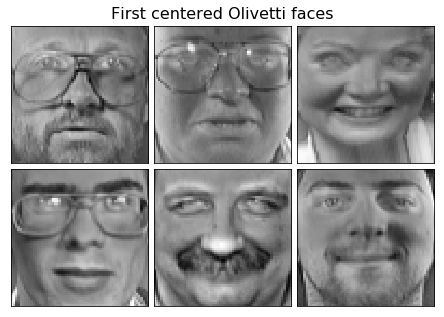

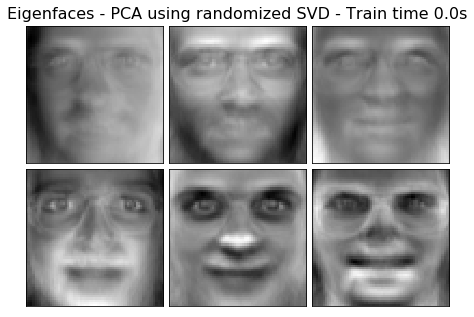

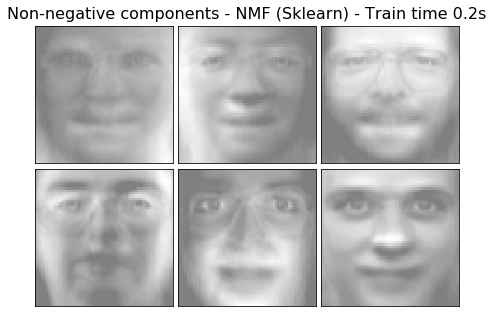

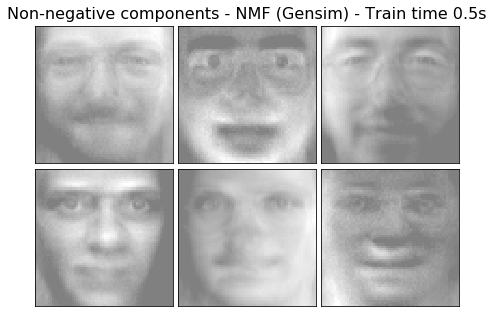

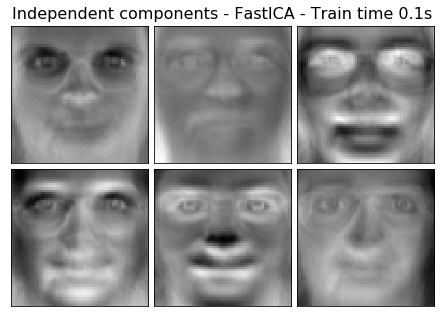

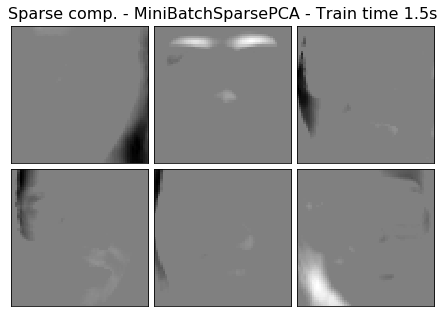

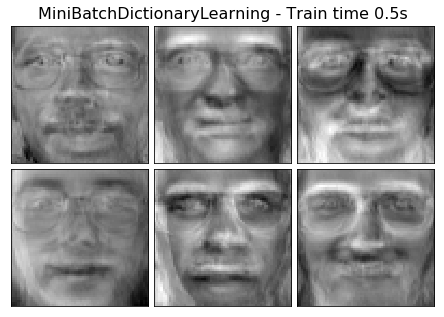

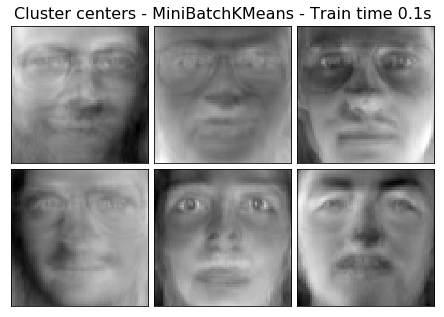

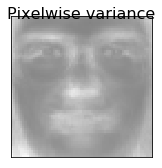

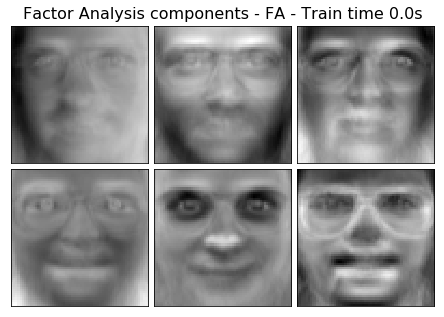

In [45]:
"""
============================
Faces dataset decompositions
============================

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .

"""
print(__doc__)

# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 claus

n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)


# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF (Sklearn)',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Non-negative components - NMF (Gensim)',
     NmfWrapper(
         bow_matrix=faces.T,
         chunksize=3,
         eval_every=400,
         passes=2,
         id2word={idx: idx for idx in range(faces.shape[1])},
         num_topics=n_components,
         minimum_probability=0,
         random_state=42,
     ),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
     decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                               n_iter=50, batch_size=3,
                                               random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
     MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                     max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]

# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time.time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time.time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

As you can see, Gensim's NMF implementation is slower than Sklearn's on **dense** vectors, while achieving comparable quality.

# Conclusion

Gensim NMF is an extremely fast and memory-optimized model. Use it to obtain interpretable topics, as an alternative to SVD / LDA.

---

The NMF implementation in Gensim was created by [Timofey Yefimov](https://github.com/anotherbugmaster/) as a part of his [RARE Technologies Student Incubator](https://rare-technologies.com/incubator/) graduation project.